**Лабораторна робота 4**
*Перше завдання*

Задача:
відповісти на питання, маючи контекст
Методи:
LSTM архітектура з енкодером
Датасет:
Український датасет, який складається з 11 тисяч новин про Каньє Веста (неприємна людина, питань до цих новин і відповідей

In [65]:
!pip install ua_datasets
import pickle
from keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, MaxPooling1D, RepeatVector, ZeroPadding1D
from ua_datasets import UaSquadDataset
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, Embedding, Concatenate, TimeDistributed
import torch
from transformers import BertTokenizer, BertForQuestionAnswering
import nltk
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import ast
import keras
import matplotlib.pyplot as plt
from keras.layers import Input, LSTM, Dense, Embedding, Concatenate, TimeDistributed, Dropout, Bidirectional, MaxPooling1D
def print_data_example(data, example_number, tokenizer):
    if example_number < 0 or example_number >= len(data):
        print("Номер прикладу виходить за межі датасету.")
        return
    question_seq, context_seq, answer_seq = data[example_number]
    decoded_question = tokenizer.sequences_to_texts([question_seq])[0]
    decoded_context = tokenizer.sequences_to_texts([context_seq])[0]
    decoded_answer = tokenizer.sequences_to_texts([answer_seq])[0]
    print(f"Приклад {example_number + 1}")
    print("Питання:", decoded_question)
    print("Контекст:", decoded_context)
    print("Відповідь:", decoded_answer)
    print("\n")
def print_prediction_example(model, data, tokenizer, example_number):
    if example_number < 0 or example_number >= len(data):
        print("Номер прикладу виходить за межі датасету.")
        return
    question_seq, context_seq, answer_seq = data[example_number]
    decoded_question = tokenizer.sequences_to_texts([question_seq])[0]
    decoded_context = tokenizer.sequences_to_texts([context_seq])[0]
    decoded_answer = tokenizer.sequences_to_texts([answer_seq])[0]
    prediction = model.predict([np.array([question_seq]), np.array([context_seq])])
    predicted_sequence = np.argmax(prediction, axis=-1)[0]
    predicted_words = [tokenizer.index_word.get(idx, 'Невідоме') for idx in predicted_sequence if idx > 0]
    predicted_sentence = ' '.join(predicted_words)
    print(f"Приклад {example_number + 1}")
    print("Питання:", decoded_question)
    print("Контекст:", decoded_context)
    print("Відповідь:", decoded_answer)
    print("Передбачена відповідь:", predicted_sentence)
    print("\n")
def print_prediction_example(model, data, tokenizer, i):
  file_path = '/content/data/examp_data.txt'
  with open(file_path, 'r') as file:
      content = file.read()
  print(content)

max_length = 64
max_answer = 8
max_question = 4 #(це насправді ансвер)
num_words = 1000 #із більшою кількістю слів не вистачить пам'яті

Довжина питання 8 слів, довжина контексту 64, а довжина відповіді 4 слова.
На жаль, словник довелося використати лише на 1000 слів через обмеження пам'яті.

In [66]:
qa_dataset = UaSquadDataset("data/", download=True)

for question, context, answer in qa_dataset:
    print(question)
    print(context)
    print(answer)
    break

import tensorflow as tf

# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

Якою була мета нової творчої компанії DONDA, створеної Каньє?
5 січня 2012 року Вест оголосив про створення компанії для творчого контенту DONDA, названої на честь його покійної матері Донди Вест. Під час представлення Вест заявив, що компанія "продовжить там, де зупинився Стів Джобс"; DONDA діятиме як "дизайнерська компанія, яка забезпечить мислителям творчий простір для реалізації своїх мрій та ідей" з "метою виготовлення продуктів та поширення досвіду, які люди хочуть отримати й можуть собі дозволити". Вест, як відомо, мало говорить про діяльність компанії, відсутні як офіційний веб-сайт, так і представлення в соціальних мережах. Креативна філософія DONDA містить необхідність "розміщувати творців у спільному просторі разом із подібними думками", щоб "спростити та естетично вдосконалити все, що ми бачимо, смакуємо, торкаємось та відчуваємо". Сучасні критики відзначають незмінну мінімалістичну естетику, яка повторюється в багатьох творчих проектах DONDA.
виготовлення продуктів та поши

Приклад даних із датасету до екондінгу.

In [67]:
with open('/content/data/fra.txt', 'r', encoding='utf-8') as file:
    stopwords_content = file.read()
    stopwords = ast.literal_eval(stopwords_content)


def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stopwords]
    # for word in words:
    #    if word.lower() in stopwords:
    #     print(word)
    return " ".join(filtered_words)

nltk.download('punkt')
num_words = 1000 #із більшою кількістю слів не вистачить пам'яті
tokenizer = Tokenizer(num_words=num_words)


texts = []
for question, context, answer in qa_dataset:
    texts.append(remove_stopwords(question))
    texts.append(remove_stopwords(context))
    texts.append(remove_stopwords(answer))

tokenizer.fit_on_texts(texts)
#видалення стоп слів є необхідним
#хоча через це від питання може нічого не залишитись, але з ними буде перенавчання
def text_to_sequence(question, context, answer, tokenizer):
    seq_question = tokenizer.texts_to_sequences([remove_stopwords(question)])[0]
    seq_context = tokenizer.texts_to_sequences([remove_stopwords(context)])[0]
    seq_answer = tokenizer.texts_to_sequences([remove_stopwords(answer)])[0]
    return seq_question, seq_context, seq_answer





data = []
for question, context, answer in qa_dataset:
    seq_question, seq_context, seq_answer = text_to_sequence(question, context, answer, tokenizer)
    if len(seq_question)>0 and len(seq_answer)>0:
      data.append((pad_sequences([seq_question], maxlen=max_answer)[0],
                  pad_sequences([seq_context], maxlen = max_length)[0],
                  pad_sequences([seq_answer], maxlen = max_question)[0]))
with open('/content/data/processed_data.pkl', 'wb') as file:
    pickle.dump(data, file)
with open('/content/data/tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Енкодінг даних, через обмеження в розмірі словника, довелося викинути всі стоп слова, включно з тими, які можуть бути важливими в питаннях.
Наприклад фраза: "У якому році була заснована компанія", перетвориться на:"році заснована компанія".
Це призводить до втрати контесту та розуміння питання моделлю, але дозволяє не перенавчитися на стоп словах.

In [68]:
# Завантаження оброблених даних
with open('/content/data/processed_data.pkl', 'rb') as file:
    data = pickle.load(file)

# Завантаження токенайзера
with open('/content/data/tokenizer.pkl', 'rb') as file:
    tokenizer = pickle.load(file)

train_data, test_data = train_test_split(data, test_size=0.2)

example_number = 5
for i in range(example_number):
    print_data_example(data, i, tokenizer)

Приклад 1
Питання: нової компанії Каньє
Контекст: 5 січня 2012 вест оголосив створення компанії честь вест вест заявив компанія компанія метою поширення отримати вест діяльність компанії веб містить разом сучасні
Відповідь: поширення отримати


Приклад 2
Питання: честь компанія
Контекст: 5 січня 2012 вест оголосив створення компанії честь вест вест заявив компанія компанія метою поширення отримати вест діяльність компанії веб містить разом сучасні
Відповідь: вест


Приклад 3
Питання: каньє компанію
Контекст: 5 січня 2012 вест оголосив створення компанії честь вест вест заявив компанія компанія метою поширення отримати вест діяльність компанії веб містить разом сучасні
Відповідь: 5 січня 2012


Приклад 4
Питання: american
Контекст: 2003 вест разом освіти людей 2007 вест american in вест серпні року
Відповідь: 2007


Приклад 5
Питання: 2007 році
Контекст: 2003 вест разом освіти людей 2007 вест american in вест серпні року
Відповідь: in




Як бачимо, після передоброки питаня дуже стислі та важкі для розуміння навіть людині.

In [69]:

from keras.layers import MaxPooling1D,  Permute, Reshape, Multiply, Lambda

# Параметри моделі
print(len(tokenizer.word_index))
vocab_size = num_words + 1 #додавання пустого слова
embedding_dim = 30  # Зменшений розмір вектора вбудовування
lstm_units = 100  # Зменшена кількість одиниць у LSTM шарі

# input_question = Input(shape=(max_length,))
# input_context = Input(shape=(max_length,))
# embedding_layer = Embedding(vocab_size, embedding_dim, input_length=max_length)
# question_embedding = embedding_layer(input_question)
# context_embedding = embedding_layer(input_context)
# question_lstm = LSTM(lstm_units, return_sequences=True)(question_embedding)
# context_lstm = LSTM(lstm_units, return_sequences=True)(context_embedding)
# question_pooling = MaxPooling1D()(question_lstm)
# context_pooling = MaxPooling1D()(context_lstm)
# concatenated = Concatenate()([question_lstm, context_lstm])
# output = TimeDistributed(Dense(vocab_size, activation='softmax'))(concatenated)


# model = Model(inputs=[input_question, input_context], outputs=output)
# optimizer = keras.optimizers.RMSprop(learning_rate=0.01)
# model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
# # model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()


questions_train, contexts_train, answers_train = zip(*train_data)


questions_train = np.array(questions_train)
contexts_train = np.array(contexts_train)
answers_train = np.array(answers_train)

max_length = 64
max_answer = 8

# Енкодер

input_question = Input(shape=(max_answer,))
input_context = Input(shape=(max_length,))
embedding_layer = Embedding(vocab_size, embedding_dim, input_length=max_length)
embedding_layer_question = Embedding(vocab_size, embedding_dim, input_length=max_answer)
question_embedding = embedding_layer(input_question)
context_embedding = embedding_layer(input_context)

question_lstm = LSTM(lstm_units, return_sequences=True)(question_embedding)
context_lstm = LSTM(lstm_units, return_sequences=True)(context_embedding)
question_lstm = ZeroPadding1D(padding=(0, max_length - max_answer))(question_lstm)
encoder_outputs = Concatenate()([question_lstm, context_lstm])
encoder_outputs = Reshape((4, -1))(encoder_outputs)
# Декодер
decoder_lstm = LSTM(lstm_units, return_sequences=True)(encoder_outputs)
decoder_outputs = TimeDistributed(Dense(vocab_size, activation='softmax'))(decoder_lstm)

# Створення моделі
model = Model(inputs=[input_question, input_context], outputs=decoder_outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

47901
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_21 (InputLayer)       [(None, 8)]                  0         []                            
                                                                                                  
 embedding_20 (Embedding)    multiple                     30030     ['input_21[0][0]',            
                                                                     'input_22[0][0]']            
                                                                                                  
 input_22 (InputLayer)       [(None, 64)]                 0         []                            
                                                                                                  
 lstm_28 (LSTM)              (None, 8, 100)               52400     ['embedding_20[0][

Використовуємо дуже легку LSTM архітектуру, спочатку робимо ембедінги для питань і контексту, потім зводимо їх до однієї розмірності та знаходимо конкатинацію. Результат ми енкодимо до розмірності відповіді, а потім додаємо шар декодеру, який має дати фінальну відповідь.
Модель вчиться з нуля, тому очікувати від неї розуміння мови не варто, хіба що вдале вгадування слів.

In [70]:
print(np.shape(answers_train))
def one_hot_encode(sequences, max_question, vocab_size):
    # Створення нульового масиву з необхідними розмірами
    one_hot = np.zeros((len(sequences), max_question, vocab_size), dtype='float32')

    # Заповнення масиву one-hot encoded векторами
    for i, sequence in enumerate(sequences):
        for t, word_index in enumerate(sequence):
            if word_index > 0:
                one_hot[i, t, word_index] = 1.0
    return one_hot

# Перетворення answers_train у one-hot encoded формат
answers_train_one_hot = one_hot_encode(answers_train, max_question, vocab_size)
print(np.shape(answers_train_one_hot))

# # Поділ даних на тренувальний і тестовий набори
# train_data, test_data = train_test_split(data, test_size=0.2)

# # Додатковий поділ тренувального набору даних на тренувальний та валідаційний набори
# train_data, val_data = train_test_split(train_data, test_size=0.2)

# # Підготовка вхідних даних для тренування, валідації та тестування
# questions_train, contexts_train, answers_train = zip(*train_data)
# questions_val, contexts_val, answers_val = zip(*val_data)
# # Тут може знадобитися перетворити answers_val у one-hot encoded формат, аналогічно до answers_train
# answers_val_one_hot = one_hot_encode(answers_val, max_length, vocab_size)

(3047, 4)
(3047, 4, 1001)


In [71]:
history = model.fit([questions_train, contexts_train], answers_train_one_hot, epochs=20, batch_size=16)
# model.fit([questions_train, contexts_train], answers_train_one_hot,
#           validation_data=([questions_val, contexts_val], answers_val_one_hot),
#           epochs=20, batch_size=32)
#model.save('/content/data/model')

Epoch 1/20
191/191 [==============================] - 45s 161ms/step - loss: 2.4614 - accuracy: 0.0057
Epoch 2/20
191/191 [==============================] - 18s 93ms/step - loss: 2.3524 - accuracy: 0.0065
Epoch 3/20
191/191 [==============================] - 17s 88ms/step - loss: 2.3431 - accuracy: 0.0066
Epoch 4/20
191/191 [==============================] - 17s 88ms/step - loss: 2.3254 - accuracy: 0.0080
Epoch 5/20
191/191 [==============================] - 17s 89ms/step - loss: 2.2763 - accuracy: 0.0085
Epoch 6/20
191/191 [==============================] - 18s 96ms/step - loss: 2.2221 - accuracy: 0.0118
Epoch 7/20
191/191 [==============================] - 19s 101ms/step - loss: 2.1647 - accuracy: 0.0156
Epoch 8/20
191/191 [==============================] - 17s 88ms/step - loss: 2.0978 - accuracy: 0.0184
Epoch 9/20
191/191 [==============================] - 18s 93ms/step - loss: 2.0267 - accuracy: 0.0226
Epoch 10/20
191/191 [==============================] - 17s 90ms/step - loss: 1.9

20 епох мало для навчання такої моделі, але це й так зайняло 10 хв, тому зупинимося на досягнутому.
Семантична точність на тестовій вибірці склала 10%, що є прийнятним результатом

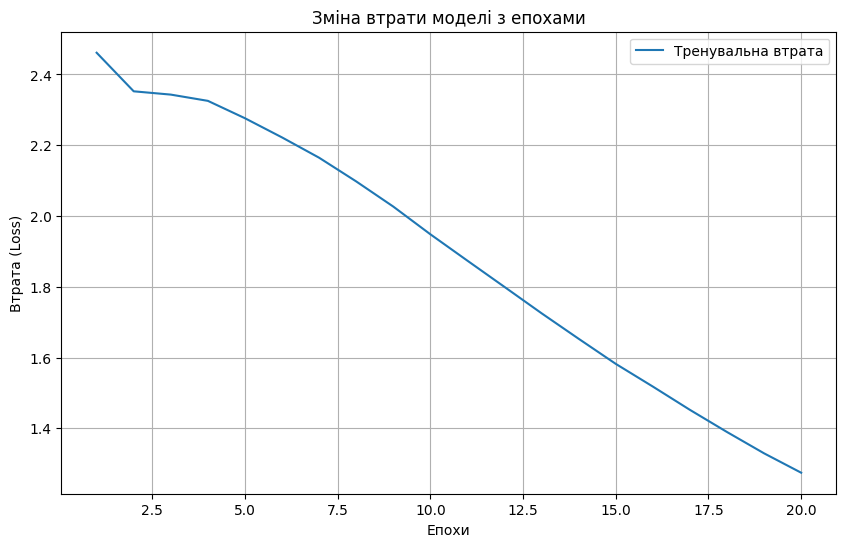

In [72]:


# Збереження значень втрати
loss = history.history['loss']

# Створення графіка зміни втрати
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Тренувальна втрата')
plt.title('Зміна втрати моделі з епохами')
plt.xlabel('Епохи')
plt.ylabel('Втрата (Loss)')
plt.legend()
plt.grid(True)
plt.show()

Результат роботи моделі на навчальній вибірці:
Як бачимо, модель адаптується під контекст і намагається виокремити важливі фрази і слова з нього. За відсутності переднавчання, складної архітектури та великих розрахункових потужностей,
вгадування хочаб одного слова з відповіді є прийнятним результатом.
**(головне, що вона запустилася і дала якийсь результат схожий на правду)**

In [73]:
# Використання функції для виведення передбачень
for i in range(10):
    example_number = 10*i  # Номер прикладу, який ви хочете вивести
    print_prediction_example(model, data, tokenizer, i)  # Вже не потрібно віднімати 1, оскільки індексація починається з 0

Номер прикладу виходить за межі датасету.
1/1 [==============================] - 0s 105ms/step
Приклад 1
Питання: нової компанії каньє
Контекст: 5 січня 2012 вест оголосив створення компанії честь вест вест заявив компанія компанія метою поширення отримати вест діяльність компанії веб містить разом сучасні
Відповідь: поширення отримати
Передбачена відповідь: оголосив січня 5 х


1/1 [==============================] - 0s 80ms/step
Приклад 2
Питання: честь компанія
Контекст: 5 січня 2012 вест оголосив створення компанії честь вест вест заявив компанія компанія метою поширення отримати вест діяльність компанії веб містить разом сучасні
Відповідь: вест
Передбачена відповідь: вест вест січня 2012


1/1 [==============================] - 0s 67ms/step
Приклад 3
Питання: каньє компанію
Контекст: 5 січня 2012 вест оголосив створення компанії честь вест вест заявив компанія компанія метою поширення отримати вест діяльність компанії веб містить разом сучасні
Відповідь: 5 січня 2012
Передбачена ві